# Notebook Description

## Purpose
This notebook implements the evaluation phase of a deep neural network model designed to identify negation in text. It includes loading test data, defining the model architecture, and evaluating the model's performance on the test set.

## Notebook Content

### 1. Dependency Installation
Imports necessary libraries for the project, including:
- `torch` for handling the neural network.
- `numpy` for numerical operations.
- `json` for loading and saving data.
- `sklearn` for evaluation metrics and confusion matrix visualization.

### 2. Data Loading
Loads test data from JSON files. The data includes word embeddings, casing information, part-of-speech (POS) tags, and labels for the test set.

### 3. Model Definition
Defines the neural network model architecture for negation detection, ensuring consistency with the model used during training.

### 4. Model Loading
Loads the trained model parameters to ensure the same model used during training is evaluated.

### 5. Evaluation
Evaluates the model on the test data by:
- Running the model on the test dataset to get predictions.
- Computing the confusion matrix and overall accuracy.
- Calculating accuracy for each label.
- Displaying the confusion matrix using a heatmap for better visualization.

### 6. Result Visualization
Visualizes the results, including the confusion matrix and accuracy metrics, to understand the model's performance on the test set.

---

In [1]:
import torch 
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import json 


In [2]:
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def save_json(data, file_path):
    with open(file_path, 'w') as f:
        json.dump(data, f)

In [3]:
test_casing_onehot = load_json('test_casing_onehot.json')
test_pos_onehot = load_json('test_pos_onehot.json')
y_test = load_json('y_test_numerical.json')
w_fast_vectors_test_reduced = load_json('w_fast_vectors_test_reduced.json')
test_word_embedding_reduced = load_json('test_word_embeddings_reduced.json')

In [4]:
print(len(test_word_embedding_reduced))

3211


In [5]:
class NegationModel(nn.Module):
    def __init__(self, word_embedding_dim, pos_embedding_dim, char_embedding_dim, casing_dim, lstm_dim, num_filters, kernel_size, conv_dropout_rate=0.5, lstm_dropout_rate=0.5, lstm_recurrent_dropout_rate=0.25):
        super(NegationModel, self).__init__()
        self.word_embedding_dim = word_embedding_dim
        self.pos_embedding_dim = pos_embedding_dim
        self.char_embedding_dim = char_embedding_dim
        self.casing_dim = casing_dim
        
        self.conv1d = nn.Conv1d(in_channels=char_embedding_dim, out_channels=num_filters, kernel_size=kernel_size)
        self.conv_dropout = nn.Dropout(conv_dropout_rate)
        self.max_pool = nn.MaxPool1d(kernel_size=3)
        
        self.bi_lstm = nn.LSTM(input_size=word_embedding_dim + pos_embedding_dim + num_filters + casing_dim,
                               hidden_size=lstm_dim, batch_first=True, bidirectional=True,
                               dropout=lstm_recurrent_dropout_rate)
        
        self.lstm_dropout = nn.Dropout(lstm_dropout_rate)
        self.fc = nn.Linear(2 * lstm_dim, 6)

        self.fc_pos = nn.Linear(pos_embedding_dim, pos_embedding_dim)
        self.fc_casing = nn.Linear(casing_dim, casing_dim)

    def forward(self, x):
        char_embeddings, word_embeddings, pos_embeddings, casing_info = x
        
        char_embeddings = char_embeddings.permute(0, 2, 1)
        char_features = self.conv1d(char_embeddings)
        char_features = self.conv_dropout(char_features)  # Dropout after Conv1D
        char_features = self.max_pool(char_features)
        char_features = char_features.view(char_features.size(0), -1, char_features.size(2))
        
        pos_embeddings = self.fc_pos(pos_embeddings)
        casing_info = self.fc_casing(casing_info)

        combined_features = torch.cat((word_embeddings, pos_embeddings, char_features, casing_info), dim=2)
        
        lstm_out, _ = self.bi_lstm(combined_features)
        lstm_out = self.lstm_dropout(lstm_out)  # Dropout after LSTM output
        
        output = self.fc(lstm_out)
        
        return output

In [6]:
# Cargar el modelo guardado
model = NegationModel(word_embedding_dim=100, pos_embedding_dim=17, char_embedding_dim=100, casing_dim=8, lstm_dim=150, num_filters=377, kernel_size=3)
checkpoint = torch.load('best_model.pth')

# Extraer el state_dict del diccionario y cargarlo en el modelo
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

NegationModel(
  (conv1d): Conv1d(100, 377, kernel_size=(3,), stride=(1,))
  (conv_dropout): Dropout(p=0.5, inplace=False)
  (max_pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (bi_lstm): LSTM(425, 150, num_layers=3, batch_first=True, dropout=0.25, bidirectional=True)
  (lstm_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=300, out_features=6, bias=True)
  (fc_pos): Linear(in_features=17, out_features=17, bias=True)
  (fc_casing): Linear(in_features=8, out_features=8, bias=True)
)

In [7]:

class CustomDataset(Dataset):
    def __init__(self, w_fast, w_vector, pos, casing, labels):
        self.w_fast = torch.tensor(w_fast,dtype=torch.float32)
        self.w_vector = torch.tensor(w_vector, dtype=torch.float32)
        self.pos = torch.tensor(pos, dtype=torch.float32) 
        self.casing = torch.tensor(casing, dtype=torch.float32)
        self.labels = torch.tensor(labels,dtype = torch.float32)

    def __len__(self):
        return len((self.w_fast))

    def __getitem__(self, idx):
        return (self.w_fast[idx], self.w_vector[idx], self.pos[idx], self.casing[idx]), self.labels[idx]


# Crear dataset y dataloader

test_dataset = CustomDataset(w_fast_vectors_test_reduced, test_word_embedding_reduced ,test_pos_onehot, test_casing_onehot, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Overall Accuracy of the model on the test dataset: 90.61 %
Accuracy for label 0: 96.99 %
Accuracy for label 1: 43.81 %
Accuracy for label 2: 39.12 %
Accuracy for label 3: 1.01 %
Accuracy for label 4: 2.12 %


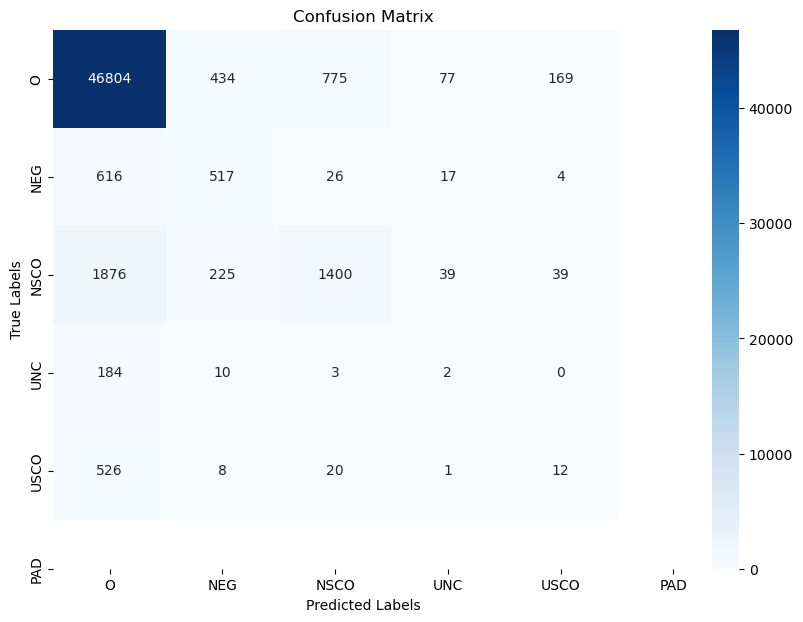

In [8]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

dict_index_tag={"O": 0, "NEG": 1, "NSCO": 2, "UNC": 3, "USCO": 4, "PAD":5}
dict_index_tag_inverted={0:"O", 1:"NEG", 2:"NSCO", 3:"UNC", 4:"USCO", 5:"PAD"}

# Inicializar listas para almacenar etiquetas y predicciones
all_labels = []
all_predictions = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)

        # Reshape outputs y labels para CrossEntropyLoss
        outputs = outputs.view(-1, outputs.size(-1))  # (batch_size * sequence_length, num_classes)
        labels = labels.view(-1, labels.size(-1))  # (batch_size * sequence_length, num_classes)

        # Convertir etiquetas one-hot a índices de clase
        labels = torch.argmax(labels, dim=1)

        # Predicción de clases
        _, predicted = torch.max(outputs, 1)

        # Filtrar etiquetas de padding
        valid_indices = labels != 5
        filtered_labels = labels[valid_indices]
        filtered_predictions = predicted[valid_indices]

        # Almacenar etiquetas y predicciones
        all_labels.extend(filtered_labels.cpu().numpy())
        all_predictions.extend(filtered_predictions.cpu().numpy())

# Convertir listas a arrays de numpy
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2, 3, 4])

# Calcular la precisión general y por etiqueta
overall_accuracy = np.sum(conf_matrix.diagonal()) / np.sum(conf_matrix)
label_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Imprimir la precisión general y por etiqueta
print('Overall Accuracy of the model on the test dataset: {:.2f} %'.format(overall_accuracy * 100))
for label, accuracy in enumerate(label_accuracy):
    print('Accuracy for label {}: {:.2f} %'.format(label, accuracy * 100))

# Mostrar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dict_index_tag_inverted.values(), yticklabels=dict_index_tag_inverted.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [9]:
print(len(w_fast_vectors_test_reduced))
print(len(test_word_embedding_reduced))
print(len(test_pos_onehot))
print(len(test_casing_onehot))
print(len(y_test))

3211
3211
3211
3211
3211
